<a href="https://colab.research.google.com/github/imshiv-10/Deep-Learning/blob/main/MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working with Images

In this tutorial, we'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: *image classification*. We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We begin by installing and importing torch and torchvision. torchvision contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically

In [163]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [164]:
dataset = MNIST(root='./data', download=True)

en this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch Dataset. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [165]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing train=False to the constructor.

In [166]:
test_dataset = MNIST(root='./data', train=False)

In [167]:
len(test_dataset)

10000

In [168]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F6711094340>, 5)

In [169]:
from PIL.Image import Image

In [170]:
Image.show(dataset[0][0]), dataset[0][1]

(None, 5)

In [171]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

label :  5


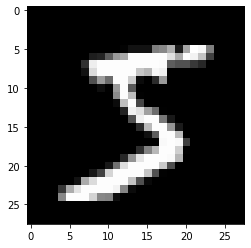

In [172]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('label : ',label)

In [173]:
len(dataset)

60000

label:  9


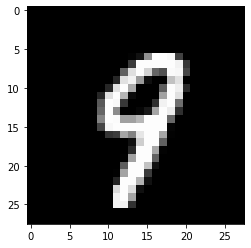

In [174]:
image, label = dataset[389]
plt.imshow(image, cmap='gray')
print('label: ', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [175]:
from torchvision.transforms import transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The torchvision.transforms module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [176]:
dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor())

In [177]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [178]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

In [179]:
img_tensor.shape

torch.Size([1, 28, 28])

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])


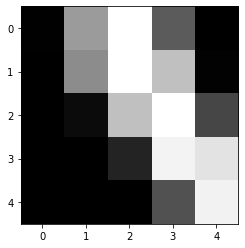

In [180]:
print(img_tensor[0, 10:15,10:15])
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

Note that we need to pass just the 28x28 matrix to plt.imshow, without a channel dimension. We also pass a color map (cmap=gray) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:
1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.
In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.
Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [181]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset=dataset, lengths=[50000,10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [182]:
def ImgShow(dataset):
  img_tensor, label = dataset
  plt.imshow(img_tensor[0,:,:], cmap='gray')
  print('Label: ', label)

Label:  5


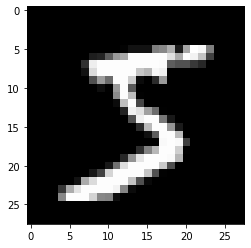

In [183]:
ImgShow(dataset[0])

Label:  1


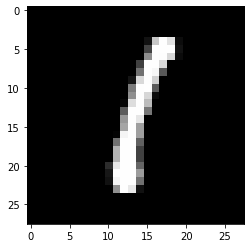

In [184]:
ImgShow(train_ds[0])

Label:  1


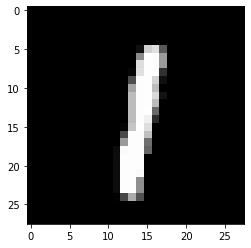

In [185]:
ImgShow(val_ds[0])

Label:  3
Label:  0
Label:  5
Label:  8
Label:  9
Label:  9
Label:  6
Label:  3
Label:  8
Label:  3


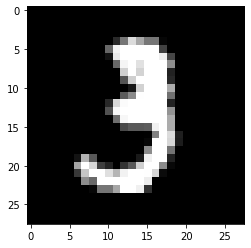

In [186]:
import numpy as np
for img in np.random.randint(100, size=10):
  ImgShow(dataset[img])

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.
We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [187]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 128 ## 50000/128 - around 390 images per batch
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size,shuffle=True)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

# Model

Now that we have prepared our data loaders, we can define our model.
- A **logistic regression model** is almost identical to a linear regression model. It contains `weights` and `bias` matrices, and the output is obtained using simple matrix operations `(pred = x @ w.t() + b).`

- As we did with linear regression, we can use **nn.Linear** to create the model instead of manually creating and initializing the matrices.
Since nn.Linear expects each training example to be a vector, each `1x28x28` image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

- The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.


In [188]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regresssion model
model = nn.Linear(input_size, num_classes)

In [189]:
model.weight.shape

torch.Size([10, 784])

In [190]:
model.bias

Parameter containing:
tensor([ 0.0105, -0.0289, -0.0237, -0.0065, -0.0152, -0.0183,  0.0156,  0.0334,
        -0.0342, -0.0083], requires_grad=True)

Of course, this model is a lot larger than our previous model in terms of the number of parameters. Let's take a look at the weights and biases.

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [191]:
for images, labels in train_loader:
  print('labels:', labels)
  print(images.shape)
  outputs = model(images)
  print(outputs)
  break

labels: tensor([0, 9, 9, 9, 6, 9, 4, 5, 0, 3, 8, 7, 3, 5, 0, 8, 1, 0, 2, 8, 1, 0, 5, 9,
        1, 3, 2, 5, 7, 6, 0, 6, 1, 8, 1, 1, 3, 0, 0, 9, 8, 3, 2, 4, 1, 2, 4, 2,
        5, 2, 1, 9, 7, 6, 7, 4, 5, 5, 6, 5, 3, 7, 9, 9, 4, 6, 9, 5, 4, 4, 5, 2,
        0, 4, 1, 0, 1, 7, 8, 2, 3, 9, 7, 4, 8, 8, 4, 9, 2, 3, 3, 1, 6, 2, 9, 1,
        8, 2, 4, 5, 4, 9, 8, 4, 1, 9, 1, 6, 3, 2, 3, 1, 6, 9, 9, 6, 2, 1, 5, 7,
        8, 2, 7, 3, 5, 9, 7, 3])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [192]:
images.shape

torch.Size([128, 1, 28, 28])

In [193]:
images.reshape(128,784).shape

torch.Size([128, 784])

In [194]:
for images, labels in train_loader:
    print(labels)
    print(images.reshape(-1,784))
    outputs = model(images.reshape(-1,784))
    print(outputs)
    break

tensor([7, 7, 7, 2, 4, 7, 4, 5, 1, 5, 1, 4, 5, 1, 8, 5, 6, 8, 6, 0, 6, 6, 5, 5,
        6, 1, 0, 7, 6, 4, 6, 1, 6, 0, 7, 1, 7, 5, 9, 0, 4, 2, 1, 7, 5, 0, 1, 0,
        1, 0, 3, 2, 2, 1, 7, 1, 7, 8, 3, 3, 5, 0, 8, 6, 7, 1, 3, 5, 1, 7, 2, 4,
        7, 5, 8, 1, 4, 1, 9, 9, 7, 4, 7, 6, 2, 4, 1, 1, 8, 9, 8, 9, 4, 3, 8, 5,
        2, 5, 4, 8, 9, 0, 8, 6, 3, 8, 1, 5, 6, 4, 2, 7, 9, 3, 9, 5, 1, 2, 1, 5,
        0, 1, 5, 4, 3, 7, 5, 1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[-0.1664, -0.1894, -0.0738,  ..., -0.1591, -0.1030, -0.0023],
        [-0.1275,  0.1043, -0.1657,  ...,  0.1117, -0.0838,  0.1345],
        [ 0.1925, -0.0608, -0.1652,  ...,  0.1258,  0.0259,  0.0568],
        ...,
        [-0.0673, -0.0211, -0.1823,  ...,  0.0688, -0.2779, -0.0660],
        [ 0.1472, -0

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.
A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [195]:
class Person:
  # class constructor
  def __init__(self,name, age):
    # object parameters
    self.name = name
    self.age = age

  # method
  def inside_classMethod(self):
    print('''heyy buddie u are now inside classs!\n 
    Welcome to the PyTorch Demon....''', {self.name})  

In [196]:
shiv = Person('shiva', 27)

In [197]:
shiv.age, shiv.name, shiv.inside_classMethod()

heyy buddie u are now inside classs!
 
    Welcome to the PyTorch Demon.... {'shiva'}


(27, 'shiva', None)

Classes can also build upon or extend the functionality of existing classes. Let's extend the nn.Module class from PyTorch to define a custom model.

In [198]:
import torch.nn

# define linear extended class 
class MnistModule(nn.Module):
  #Intializing the constructor method
  def __init__(self) -> None:
    # calling nn.module classes and methods
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  # initializing the forward defination
  def forward(self, xb):
    xb = xb.reshape(-1,784)
    out = self.linear(xb)
    return out
model = MnistModule()    


Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.
xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.
Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [201]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [202]:
print(model.linear.parameters, model.linear.weight.shape, model.linear.bias.shape)

<bound method Module.parameters of Linear(in_features=784, out_features=10, bias=True)> torch.Size([10, 784]) torch.Size([10])


In [203]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0354, -0.0270, -0.0066,  ...,  0.0212,  0.0069,  0.0330],
         [-0.0278,  0.0203, -0.0042,  ...,  0.0257,  0.0125, -0.0182],
         [-0.0292,  0.0338, -0.0323,  ...,  0.0256,  0.0177, -0.0196],
         ...,
         [ 0.0306, -0.0012,  0.0210,  ..., -0.0204, -0.0236,  0.0019],
         [ 0.0241,  0.0216, -0.0130,  ...,  0.0004,  0.0097, -0.0320],
         [ 0.0102, -0.0083, -0.0042,  ..., -0.0336,  0.0211,  0.0317]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0209, -0.0084, -0.0247, -0.0065, -0.0004,  0.0283,  0.0323, -0.0007,
         -0.0191,  0.0340], requires_grad=True)]

We can use our new custom model in the same way as before. Let's see if it works.

In [206]:
for images, labels in train_loader:
  print(images.shape)
  outputs = model(images)
  break

print('output.shape:', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
output.shape: torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.2230,  0.2580, -0.1762, -0.0653, -0.2529, -0.0262,  0.3520,  0.4744,
          0.0227, -0.0560],
        [ 0.1958,  0.0860, -0.1869, -0.0745, -0.1861, -0.0187,  0.2619,  0.3107,
         -0.0758, -0.1444]])


In [205]:
outputs

tensor([[ 0.3286, -0.2267,  0.2412,  ...,  0.2019, -0.1191, -0.2076],
        [ 0.1542,  0.2186,  0.1028,  ...,  0.2024,  0.0355, -0.0710],
        [ 0.3333,  0.1972,  0.2307,  ...,  0.3703, -0.0710,  0.0083],
        ...,
        [ 0.3872,  0.2406,  0.0581,  ...,  0.3367, -0.1247, -0.3083],
        [ 0.2733, -0.1552, -0.0162,  ...,  0.4476,  0.0186, -0.1572],
        [ 0.2960,  0.1545, -0.0988,  ...,  0.3276, -0.0127, -0.1869]],
       grad_fn=<AddmmBackward0>)

For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.
To convert the output rows into probabilities, we use the softmax function, which has the following formula:

For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive. 

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [207]:
import torch.nn.functional as F

The softmax function is included in the torch.nn.functional package and requires us to specify a dimension along which the function should be applied.

In [211]:
outputs[:1]

tensor([[ 0.2230,  0.2580, -0.1762, -0.0653, -0.2529, -0.0262,  0.3520,  0.4744,
          0.0227, -0.0560]], grad_fn=<SliceBackward0>)

In [212]:
probs = F.softmax(outputs, dim=1)

In [213]:
probs

tensor([[0.1129, 0.1169, 0.0758,  ..., 0.1452, 0.0924, 0.0854],
        [0.1177, 0.1055, 0.0803,  ..., 0.1321, 0.0897, 0.0838],
        [0.1118, 0.0997, 0.0881,  ..., 0.1118, 0.0991, 0.0805],
        ...,
        [0.1482, 0.1076, 0.0838,  ..., 0.1801, 0.0792, 0.0678],
        [0.1123, 0.1084, 0.1045,  ..., 0.1292, 0.1102, 0.0820],
        [0.1634, 0.1545, 0.0793,  ..., 0.1097, 0.0842, 0.0649]],
       grad_fn=<SoftmaxBackward0>)

In [216]:
print('sum of ',torch.sum(probs[0]).item())

sum of  1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [217]:
max_probs, preds = torch.max(probs, dim=1)

In [218]:
 torch.max(probs, dim=1)

torch.return_types.max(
values=tensor([0.1452, 0.1321, 0.1241, 0.1490, 0.1823, 0.1253, 0.1418, 0.1277, 0.1461,
        0.1500, 0.1431, 0.1452, 0.1263, 0.1466, 0.1234, 0.1238, 0.1355, 0.1510,
        0.1427, 0.1470, 0.1545, 0.1279, 0.1375, 0.1492, 0.1271, 0.1280, 0.1178,
        0.1897, 0.1450, 0.1369, 0.1180, 0.1449, 0.1340, 0.1253, 0.1278, 0.1341,
        0.1362, 0.1471, 0.1324, 0.1749, 0.1488, 0.1675, 0.1183, 0.1336, 0.1388,
        0.1693, 0.1488, 0.1446, 0.1452, 0.1433, 0.1407, 0.1518, 0.1467, 0.1295,
        0.1447, 0.1488, 0.1431, 0.1349, 0.1394, 0.1328, 0.1599, 0.1446, 0.1396,
        0.1595, 0.1460, 0.1238, 0.1420, 0.1273, 0.1555, 0.1330, 0.1406, 0.1224,
        0.1230, 0.1380, 0.1308, 0.1776, 0.1450, 0.1303, 0.1342, 0.1457, 0.1405,
        0.1603, 0.1189, 0.1360, 0.1250, 0.1541, 0.1472, 0.1303, 0.1450, 0.1266,
        0.1216, 0.1377, 0.1332, 0.1263, 0.1256, 0.1422, 0.1484, 0.1507, 0.1236,
        0.1328, 0.1246, 0.1634, 0.1522, 0.1273, 0.1446, 0.1577, 0.1230, 0.1280,
        0

In [222]:
probs

tensor([[0.1129, 0.1169, 0.0758,  ..., 0.1452, 0.0924, 0.0854],
        [0.1177, 0.1055, 0.0803,  ..., 0.1321, 0.0897, 0.0838],
        [0.1118, 0.0997, 0.0881,  ..., 0.1118, 0.0991, 0.0805],
        ...,
        [0.1482, 0.1076, 0.0838,  ..., 0.1801, 0.0792, 0.0678],
        [0.1123, 0.1084, 0.1045,  ..., 0.1292, 0.1102, 0.0820],
        [0.1634, 0.1545, 0.0793,  ..., 0.1097, 0.0842, 0.0649]],
       grad_fn=<SoftmaxBackward0>)

In [223]:
labels

tensor([9, 9, 5, 2, 8, 1, 3, 2, 3, 5, 6, 9, 6, 0, 9, 4, 3, 0, 8, 6, 0, 3, 4, 8,
        7, 7, 1, 5, 9, 1, 4, 9, 9, 4, 6, 7, 7, 0, 1, 7, 6, 3, 1, 6, 8, 3, 8, 9,
        9, 8, 5, 3, 5, 1, 6, 6, 9, 0, 0, 1, 6, 8, 2, 8, 8, 7, 9, 9, 2, 9, 2, 3,
        7, 4, 9, 3, 6, 4, 1, 3, 4, 7, 6, 4, 7, 5, 8, 7, 5, 1, 6, 6, 5, 9, 1, 5,
        8, 3, 0, 0, 6, 3, 8, 8, 8, 0, 1, 9, 0, 9, 6, 5, 9, 9, 6, 5, 4, 5, 1, 6,
        2, 1, 2, 5, 2, 5, 2, 9])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

# Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the accuracy of the predictions.

In [224]:
outputs[:2]

tensor([[ 0.2230,  0.2580, -0.1762, -0.0653, -0.2529, -0.0262,  0.3520,  0.4744,
          0.0227, -0.0560],
        [ 0.1958,  0.0860, -0.1869, -0.0745, -0.1861, -0.0187,  0.2619,  0.3107,
         -0.0758, -0.1444]], grad_fn=<SliceBackward0>)

In [226]:
torch.sum(preds == labels)

tensor(10)

In [253]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))


The == operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing True for unequal elements and False for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.
Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.
Let's calculate the accuracy of the current model on the first batch of data.


In [228]:
accuracy(outputs, labels)

tensor(0.0781)

In [229]:
probs

tensor([[0.1129, 0.1169, 0.0758,  ..., 0.1452, 0.0924, 0.0854],
        [0.1177, 0.1055, 0.0803,  ..., 0.1321, 0.0897, 0.0838],
        [0.1118, 0.0997, 0.0881,  ..., 0.1118, 0.0991, 0.0805],
        ...,
        [0.1482, 0.1076, 0.0838,  ..., 0.1801, 0.0792, 0.0678],
        [0.1123, 0.1084, 0.1045,  ..., 0.1292, 0.1102, 0.0820],
        [0.1634, 0.1545, 0.0793,  ..., 0.1097, 0.0842, 0.0649]],
       grad_fn=<SoftmaxBackward0>)

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [230]:
outputs

tensor([[ 0.2230,  0.2580, -0.1762,  ...,  0.4744,  0.0227, -0.0560],
        [ 0.1958,  0.0860, -0.1869,  ...,  0.3107, -0.0758, -0.1444],
        [ 0.1621,  0.0476, -0.0757,  ...,  0.1624,  0.0417, -0.1667],
        ...,
        [ 0.3752,  0.0547, -0.1951,  ...,  0.5702, -0.2511, -0.4075],
        [ 0.1841,  0.1487,  0.1121,  ...,  0.3241,  0.1644, -0.1302],
        [ 0.6296,  0.5735, -0.0935,  ...,  0.2311, -0.0336, -0.2941]],
       grad_fn=<AddmmBackward0>)

In [231]:
loss_fn = F.cross_entropy

In [234]:
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3551, grad_fn=<NllLossBackward0>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.



In [263]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = [] # for recording epoch-wise results

  for epoch in range(epochs):
    #training phase 
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history    

In [238]:
l1 = [1, 2, 3, 4, 5]

In [241]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [242]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

Finally, let's redefine the MnistModel class to include additional methods training_step, validation_step, validation_epoch_end, and epoch_end used by fit and evaluate.

In [260]:
class MnistModule(nn.Module):
  def __init__(self):
      super().__init__()
      self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
      xb = xb.reshape(-1,784)
      out = self.linear(xb)
      return out

  def training_step(self, batch):
      images, labels = batch
      out = self(images) # generate predictions
      loss = F.cross_entropy(out,labels) # finding loss
      return loss

  def validation_step(self, batch):
      images, labels = batch
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      accu = accuracy(out, labels)          # calculate accuracy
      return {'Val_loss': loss, 'Val_accu': accu}

  def validation_epoch_end(self, outputs):
      batch_loss = [x['Val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_loss).mean()
      batch_accu =[x['Val_accu'] for x in outputs]
      epoch_accu = torch.stack(batch_accu).mean()
      return {'Val_loss': epoch_loss.item(), 'Val_accu': epoch_accu.item() }

  def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss:{:.4f}, Val_accu:{:.4f}".format(epoch,result['Val_loss'],result['Val_accu']))

model = MnistModule()         




In [251]:
model.parameters

<bound method Module.parameters of MnistModule(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)>

In [256]:
result0 = evaluate(model, val_loader)
result0

{'Val_loss': 2.3328614234924316, 'Val_accu': 0.12786787748336792}

he initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).
We are now ready to train the model. Let's train for five epochs and look at the results.

In [264]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss:1.9314, Val_accu:0.6301
Epoch [1], val_loss:1.6637, Val_accu:0.7341
Epoch [2], val_loss:1.4696, Val_accu:0.7609
Epoch [3], val_loss:1.3177, Val_accu:0.7882
Epoch [4], val_loss:1.2008, Val_accu:0.7999


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs. Try changing the learning rates and number of epochs in each of the cells below.

In [265]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss:1.1106, Val_accu:0.8113
Epoch [1], val_loss:1.0361, Val_accu:0.8204
Epoch [2], val_loss:0.9794, Val_accu:0.8255
Epoch [3], val_loss:0.9251, Val_accu:0.8322
Epoch [4], val_loss:0.8879, Val_accu:0.8340


In [266]:
history3 = fit(5, 0.001, model, train_loader, val_loader)


Epoch [0], val_loss:0.8525, Val_accu:0.8374
Epoch [1], val_loss:0.8171, Val_accu:0.8443
Epoch [2], val_loss:0.7913, Val_accu:0.8442
Epoch [3], val_loss:0.7683, Val_accu:0.8476
Epoch [4], val_loss:0.7440, Val_accu:0.8505


In [267]:
history4 = fit(5, 0.001, model, train_loader, val_loader)


Epoch [0], val_loss:0.7228, Val_accu:0.8532
Epoch [1], val_loss:0.7058, Val_accu:0.8552
Epoch [2], val_loss:0.6864, Val_accu:0.8577
Epoch [3], val_loss:0.6748, Val_accu:0.8570
Epoch [4], val_loss:0.6625, Val_accu:0.8580


In [275]:
history
accuracies = [result['Val_accu'] for result in history]

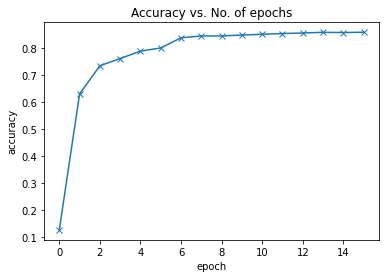

In [276]:
history = [result0] + history1 + history2 + history4
accuracies = [result['Val_accu'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.
The more likely reason that the model just isn't powerful enough. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a linear function of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc.
Let's save our work using jovian.commit. Along with the notebook, we can also record some metrics from our training.

# Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the ToTensor transform.

In [277]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


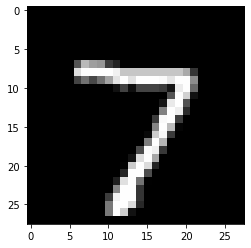

In [278]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [279]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

img.unsqueeze simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Label: 7 , Predicted: 7


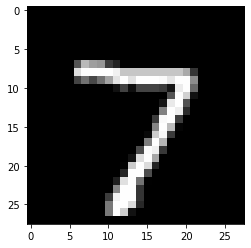

In [280]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


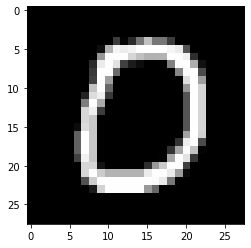

In [281]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


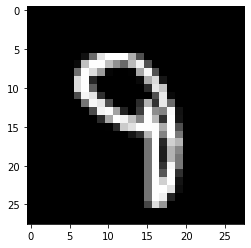

In [282]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


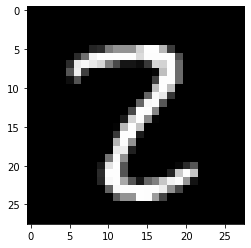

In [283]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.
As a final step, let's also look at the overall loss and accuracy of the model on the test set.